In [187]:
#pip install ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


In [188]:
df = pd.read_csv("gld_price_data.csv")
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


There are no missing values, and there is a gap on every weekend. But because the stock market is closed on weekends, I don't consider these as "gaps", as the data is sequential and there is no change to the exchange rates on Saturday and Sunday.

In [189]:
df = df.iloc[1200:]

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 1200 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1090 non-null   object 
 1   SPX      1090 non-null   float64
 2   GLD      1090 non-null   float64
 3   USO      1090 non-null   float64
 4   SLV      1090 non-null   float64
 5   EUR/USD  1090 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.2+ KB


In [191]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,2133.244036,119.238710,19.489070,16.757224,1.191676
std,287.257574,7.024322,10.800138,2.085915,0.107711
min,1573.089966,100.500000,7.960000,13.060000,1.039047
25%,1940.294983,115.167504,10.922500,15.412500,1.103226
50%,2081.214966,119.875000,13.400000,16.175000,1.149855
75%,2340.735046,124.690002,33.630001,18.527501,1.286675
max,2872.870117,136.750000,39.290001,23.590000,1.393088


In [192]:
# --- ADAT ELŐKÉSZÍTÉS ---
from sklearn.preprocessing import MinMaxScaler
import numpy as np

value_column = "GLD"  # vagy ami az idősorod oszlopa

In [193]:
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df = df[[value_column]]
df.index = df.index * 0.1 + 1
df.head()

,GLD
121.0,0.872552
121.1,0.830069
121.2,0.637241
121.3,0.646345
121.4,0.633655


In [194]:
# let's figure out a good cutoff point for train/test
# 67% for training, 25% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


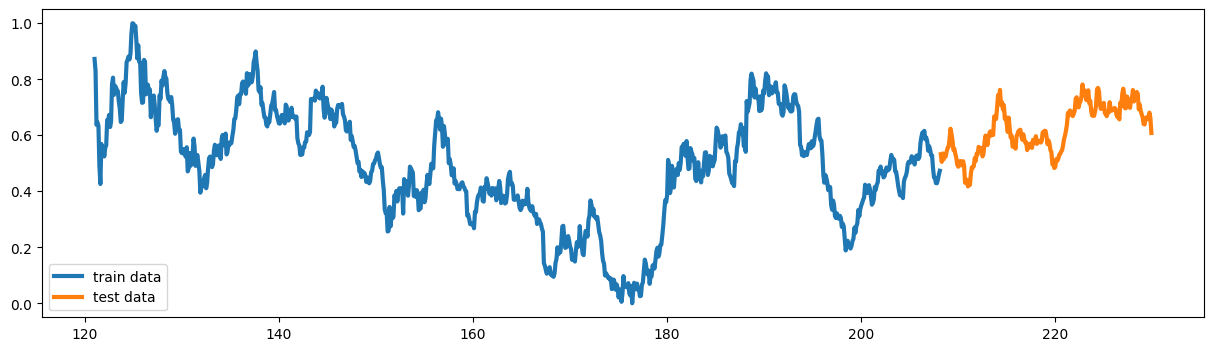

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [196]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn

# due to this dateset being monthly sales for each year
# 12 is probably a good look_back so it captures one year of trends
# at a time
look_back  = 60
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [197]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_gld.keras', monitor='val_loss', mode='min', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

callback_list = [mc, early_stop]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 32

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
# Első réteg: vissza kell térnie a szekvenciával (return_sequences=True)
model.add(LSTM(64, activation="tanh", return_sequences=True)) 
# Második réteg: ez a kimeneti réteg előtt van, return_sequences=False
model.add(LSTM(32, activation="tanh"))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=50, verbose=1, validation_data=test_generator, callbacks=callback_list )


Epoch 1/50


c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


812/812 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0101 - val_loss: 0.0012
Epoch 2/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 3/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 4/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 0.0037 - val_loss: 6.9465e-04
Epoch 5/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 0.0027 - val_loss: 8.1405e-04
Epoch 7/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 8/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 0.0022 - val_loss: 6.5978e-04
Epoch 9/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 0.0022 - val_loss: 5.6937e-04
Epoch 10/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 0.0021 - val_loss: 9.6618e-04
Epoch 11/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 0.0020 - val_loss: 6.7365e-04
Epoch 12/50
812/8

<Axes: >

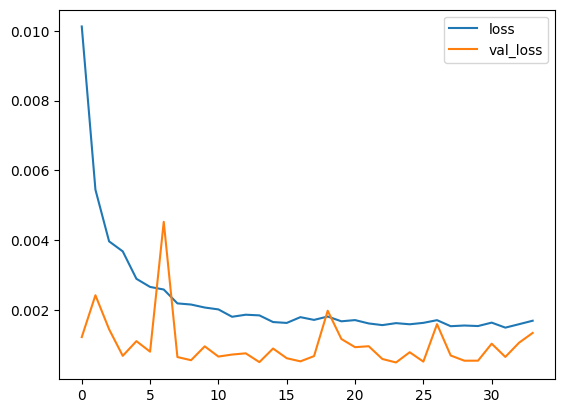

In [198]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [199]:
# training accuracy?

In [200]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_gld.keras")

In [201]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

812/812 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0010
Training loss: 0.0010360676096752286
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0456e-04
Testing loss: 0.0005045583820901811


In [202]:
test_predictions  = model.predict(test_generator)

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [203]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
2.67 %

MAE
0.02 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.9


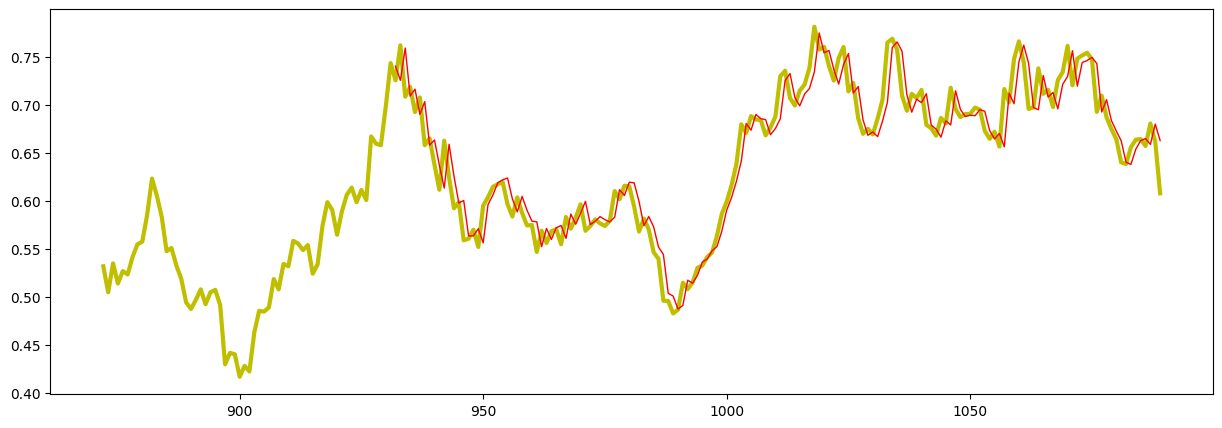

In [204]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [205]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0010
Training loss: 0.0010360676096752286
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0456e-04
Testing loss: 0.0005045583820901811


In [210]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(600):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

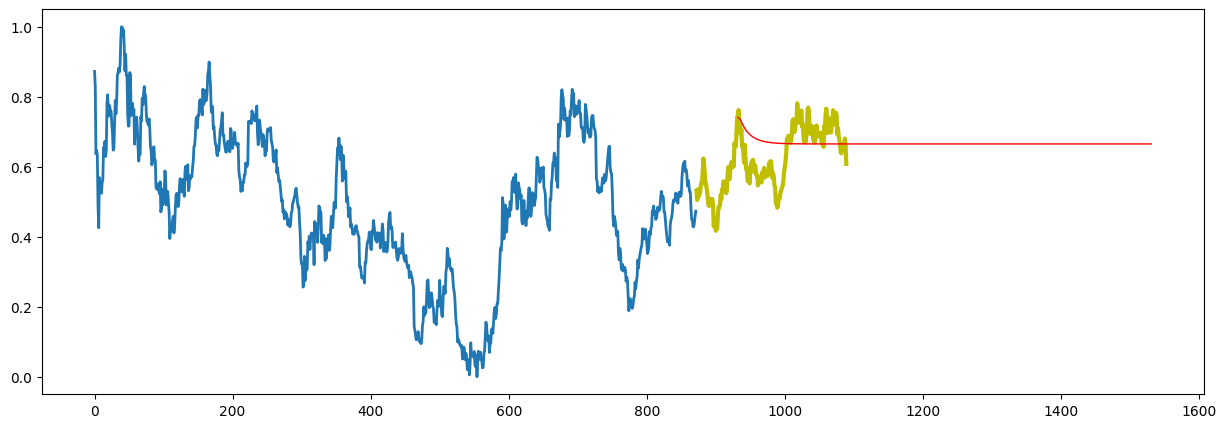

In [211]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()